# Motion Graphs

![title](img/title.png)

The idea of a motion graph is to take a bunch of animation and build a graph from frame to frame.  A frame is connected to the next frame in the animation and 0 or several frames in different animations if the motion are close to each other.

![title](img/graph.png)

### Import external python

In [24]:
%matplotlib inline
%run ../skeleton.py
%run ../animation.py

### Import skeleton and animations

In [25]:
skeleton = load_skeleton(r'../skeleton.dat')
animations = [load_animation("anim_{}.dat".format(i)) for i in range(28)]

### Drawing methods
Let's define a few function to display a skeleont, animation and point cloud

In [5]:
import k3d

def plot_skeleton(plot, skeleton):
    for i in range(len(skeleton._bones)):
        if skeleton._bones[i]._parentId >= 0:
            startM = skeleton.globalMatrix(i)
            endM = skeleton.globalMatrix(skeleton._bones[i]._parentId)
            p = k3d.line([startM[3][:3], endM[3][:3]], width=0.05, color=0x2233FF)
            plot += p

def plot_animation(plot, skeleton, animation):
    #plot skeleton at 2 frames
    keycount, tracks = animation
    skeleton.load_animation(animation, int(keycount/2) )
    plot_skeleton(plot, skeleton)

    
    #plot trajectories
    boneIds = [skeleton.bone_id(n) for n in ['Hips','LeftHand','RightHand','LeftFoot','RightFoot']]
    lines = [[] for i in range(len(boneIds))]
    for frame in range(keycount):
        skeleton.load_animation(animation, frame )
        for i,boneId in enumerate(boneIds):
            lines[i].append(skeleton.globalMatrix(boneId)[3][:3])
            
    for i in range(len(boneIds)):
        p = k3d.line(lines[i], shader='simple', color=0xFF22FF)
        plot += p
        
        
def plot_anchor(plot, skeleton):
    p = k3d.points([
            skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))
        ], point_size=0.02, color=0x55FF00)
    plot += p
        
    
        
plot = k3d.plot()
plot_animation(plot, skeleton, animations[0])   
plot.display()

Output()

## Compare Animation Frames

We want to compare to frame of two animations.

In [6]:
plot = k3d.plot()
plot_animation(plot, skeleton, animations[0])   
plot_animation(plot, skeleton, animations[1])
plot.display()

Output()

To compare the best solution is to compare a point clouds instead of bone orientation

In [7]:
plot = k3d.plot()  
skeleton = load_skeleton(r'../skeleton.dat')
plot_skeleton(plot,skeleton)
plot_anchor(plot,skeleton)
plot.display()

Output()

In [17]:
from scipy.optimize import minimize

def point_cloud(skeleton):
    cloud = np.array([skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))])
    average = np.average(cloud, axis=0)
    average[2] = 0
    return cloud - average

def point_cloud_and_average(skeleton):
    cloud = np.array([skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))])
    average = np.average(cloud, axis=0)
    average[2] = 0
    return cloud, average

def rotate_cloud(cloud, theta):
    c, s = np.cos(theta), np.sin(theta)
    M = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    return cloud.dot(M)

def align_cloud(cloud, x,y,t):
    cloud = rotate_cloud(cloud, t)
    return cloud + np.array([x,y,0])

skeleton.load_animation(animations[0], 10 )
cloud_a = point_cloud(skeleton)

skeleton.load_animation(animations[1], 35 )
cloud_b = align_cloud(point_cloud(skeleton), 1,0,0)

plot = k3d.plot()
p = k3d.points(cloud_a, point_size=0.02, color=0x55FF00)
plot += p

p = k3d.points(cloud_b, point_size=0.02, color=0xFF5500)
plot += p

plot.display()

def _objective(xyt):
    x,y,t = xyt
    cloud = align_cloud(cloud_b, x,y,t)
    v = cloud_a - cloud
    return np.sum(v*v) * 0.5

sol = minimize(_objective, [0,0,0], method='SLSQP')
print (sol)

p = k3d.points(align_cloud(cloud_b,*sol.x), point_size=0.02, color=0x0000FF)
plot += p

print (_objective([0,0,0]))
print (_objective(sol.x))

Output()

     fun: 1.732317711786871
     jac: array([-0.00031982, -0.00046052,  0.00112501])
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([-0.98582923, -0.16777801, -0.1685701 ])
46.8235559393545
1.732317711786871


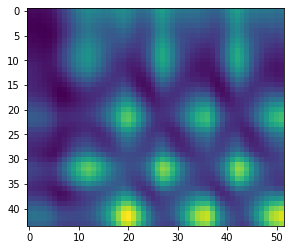

In [18]:
def compute_errors_between_2_animations(anim_a, anim_b, skeleton):
    keycount_a, _ = anim_a
    anim_a_clouds = []
    for frame in range(keycount_a):
        skeleton.load_animation(anim_a, frame)
        anim_a_clouds.append(point_cloud(skeleton))
        
    keycount_b, _ = anim_b
    anim_b_clouds = []
    for frame in range(keycount_b):
        skeleton.load_animation(anim_b, frame)
        anim_b_clouds.append(point_cloud(skeleton))
        
    def _objective(xyt, cloud_a, cloud_b):
        cloud = align_cloud(cloud_b, *xyt)
        v = cloud_a - cloud
        return np.sum(v*v) * 0.5
    
    errors = []
    for frame_a in range(keycount_a):
        errors.append([])
        for frame_b in range(keycount_b):
            extra = (anim_a_clouds[frame_a], anim_b_clouds[frame_b])
            sol = minimize(_objective, [0,0,0], method='SLSQP', args=extra)
            errors[frame_a].append(sol.fun)
        
    return np.array(errors)

errors = compute_errors_between_2_animations(animations[0], animations[2], skeleton)
import matplotlib.pyplot as plt
plt.imshow( errors )

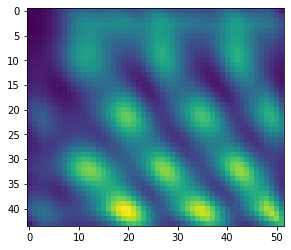

In [19]:
def compute_errors_between_2_animations_range(anim_a, anim_b, skeleton):
    keycount_a, _ = anim_a
    anim_a_clouds = []
    for frame in range(keycount_a):
        skeleton.load_animation(anim_a, frame)
        anim_a_clouds.append(point_cloud(skeleton))
        
    keycount_b, _ = anim_b
    anim_b_clouds = []
    for frame in range(keycount_b):
        skeleton.load_animation(anim_b, frame)
        anim_b_clouds.append(point_cloud(skeleton))
        
    def _objective(xyt, cloud_a, cloud_b, weights):
        cloud = align_cloud(cloud_b, *xyt)
        v = cloud_a - cloud
        sqr = np.sum(v*v, axis=1)
        return np.sum(sqr * weights) * 0.5
    
    def _concat(arg, arg2):
        a = np.concatenate((arg[0],arg2[0]), axis=0)
        b = np.concatenate((arg[1],arg2[1]), axis=0)
        w = np.concatenate((arg[2],arg2[2]))
        return (a,b,w)
    
    def _build_lists(frame_a, frame_b, weight):
        a = anim_a_clouds[frame_a]
        b = anim_b_clouds[frame_b]
        w = np.array([weight]*a.shape[0])
        return (a,b,w)
    
    errors = []
    for frame_a in range(keycount_a):
        errors.append([])
        for frame_b in range(keycount_b):
               
            arg = _build_lists(frame_a, frame_b, 1.0)
            
            if frame_a > 0 and frame_b > 0:
                arg2 = _build_lists(frame_a-1, frame_b-1, 0.9)
                arg = _concat(arg2, arg)
                
            if frame_a > 1 and frame_b > 1:
                arg2 = _build_lists(frame_a-2, frame_b-2, 0.7)
                arg = _concat(arg2, arg)
                
            if frame_a > 2 and frame_b > 2:
                arg2 = _build_lists(frame_a-3, frame_b-3, 0.5)
                arg = _concat(arg2, arg)
                
            if frame_a < keycount_a-1 and frame_b < keycount_b-1:
                arg2 = _build_lists(frame_a+1, frame_b+1, 0.9)
                arg = _concat(arg, arg2)
                
            if frame_a < keycount_a-2 and frame_b < keycount_b-2:
                arg2 = _build_lists(frame_a+2, frame_b+2, 0.7)
                arg = _concat(arg, arg2)
                
            if frame_a < keycount_a-3 and frame_b < keycount_b-3:
                arg2 = _build_lists(frame_a+3, frame_b+3, 0.5)
                arg = _concat(arg, arg2)
      
            sol = minimize(_objective, [0,0,0], method='SLSQP', args=arg)
            errors[frame_a].append(sol.fun)
        
    return np.array(errors)

errors_r = compute_errors_between_2_animations_range(animations[0], animations[2], skeleton)
import matplotlib.pyplot as plt
plt.imshow( errors_r )



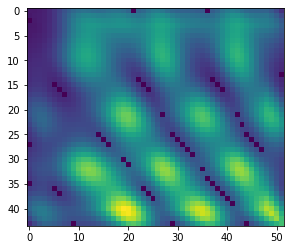

In [20]:
def local_minima(array2d):
    return np.array(
        np.where( 
            ((array2d <= np.roll(array2d,  1, 0)) &
            (array2d <= np.roll(array2d, -1, 0)) &
            (array2d <= np.roll(array2d,  1, 1)) &
            (array2d <= np.roll(array2d, -1, 1)))
        )
    ).T

minimas = local_minima(errors_r)

errors_show = errors_r.copy()
for a, b in minimas:
    errors_show[a][b] = -2
    pass
plt.imshow( errors_show )

In [ ]:
def compute_errors_between_all(animations, skeleton):
    count = len(animations)
    accessors = np.array([[-1]*count for i in range(count)])
    datas = []
    for i in range(count):
        for j in range(count):
            
            #already done ?
            if accessors[i,j] < 0:
                dists = compute_errors_between_2_animations_range(animations[i], animations[j], skeleton)
                datas.append(dists)
                accessors[i,j] = len(datas)-1
                
                if accessors[j,i] < 0:
                    datas.append(dists.T)
                    accessors[j,i] = len(datas)-1
    return datas, accessors

datas, accessors = compute_errors_between_all(animations, skeleton)

animcount = len(animations)
fig, _axs = plt.subplots(nrows=animcount, ncols=animcount)
for i in range(animcount):
    for j in range(animcount):
        _axs[i,j].imshow(datas[accessors[i,j]])

In [ ]:
# commented out to avoid calling it by mistake

#import pickle
#x = pickle.dumps((datas, accessors))
#with open(r'animation_errors_data.dat', 'wb') as f:
#    f.write(x)

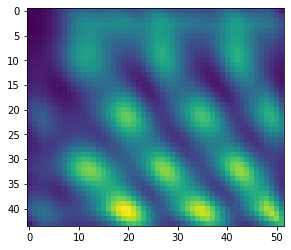

In [21]:
import pickle
datas, accessors = pickle.load(open(r'animation_errors_data.dat','rb'))
import matplotlib.pyplot as plt
plt.imshow( datas[3] )

## Build the graph

![title](img/graph.png)

In [22]:
motion_graph = []

class graphnode(object):
    def __init__(self, animid, frameid):
        self.animid = animid
        self.frameid = frameid
        self.children = []

#first add all the animations as is in the graph
for animid, animation in enumerate(animations) :
    keycount, frames = animation
    parentnode = None
    nodelist = []
    cloud = []
    for frameid in range(keycount):
        #if we enter in an animation with constant data we stop
        skeleton.load_animation(animation, frameid)
        ncloud = point_cloud(skeleton)
        if frameid > 0:
            v = cloud - ncloud
            dist = np.sum(v*v) * 0.5
            if dist < 0.00001:
                print ('skipped {} {}'.format(animid, frameid))
                break
        cloud = ncloud
        node = graphnode(animid, frameid)
        if parentnode :
            parentnode.children.append(node)
        nodelist.append(node)
        parentnode = node
    motion_graph.append(nodelist)
        
animcount = len(animations)
#compute extra connections
for i in range(animcount):
    for j in range(animcount):
        errors = datas[accessors[i,j]]
        minimas = local_minima(errors)
        keycount, _ = animations[j]
        
        for a, b in minimas:
            if errors[a][b] < 2 and b < keycount-1: #below an error threshold
                if i != j or a > b+4 or a < b+4: #at least 5 frames away in the same animation
                    if len(motion_graph[i]) > a and len(motion_graph[j]) > b+1: #make sure we have that node in the graph first
                        motion_graph[i][a].children.append(motion_graph[j][b+1])
        
connectivity = [len(node.children) for anim in motion_graph for node in anim]
print(np.mean(connectivity))
print(np.max(connectivity))
print(np.min(connectivity))
print(np.array(np.unique(connectivity, return_counts=True)).T)

skipped 4 66
skipped 25 73
4.074242424242424
36
0
[[  0   2]
 [  2 468]
 [  3 341]
 [  4 148]
 [  5  82]
 [  6  57]
 [  7 118]
 [  8  50]
 [  9  12]
 [ 10  10]
 [ 11   1]
 [ 12   2]
 [ 13   4]
 [ 14   6]
 [ 15   1]
 [ 16   2]
 [ 17   1]
 [ 19   1]
 [ 21   2]
 [ 23   1]
 [ 24   2]
 [ 26   3]
 [ 27   2]
 [ 35   2]
 [ 36   2]]


In [29]:
import random

tracks_buffer = skeleton.create_tracks_buffer()
discontinuities = []
node = motion_graph[0][0]

plot = k3d.plot()

def plot_Hips(plot, skeleton, color):
    boneId = skeleton.bone_id('Hips')
    M = skeleton.globalMatrix(boneId)
    p = k3d.points(M[3][:3], point_size=0.05, color=color)
    plot += p

        

def _objective(xyt, cloud_a, cloud_b):
    cloud = align_cloud(cloud_b, *xyt)
    v = cloud_a - cloud
    return np.sum(v*v) * 0.5

for i in range(1000):
    child_count = len( node.children )
    if child_count == 0 : #we are stuck
        print('blocked')
        break
    nextid = 0
    if random.randint(0,5) > 1:
        nextid = random.randint(0,child_count-1)
    

    #move to the next frame
    prevnode = node
    node = node.children[nextid]
    
    #if we are jumping around in the motion graph, we need to align the two animations
    if i != 0 and ( prevnode.animid != node.animid or prevnode.frameid != node.frameid-1 ):
        discontinuities.append(i)
        #we will solve clouds for previous node and next node
        #the skeleton already holds the previous frame
        cloud_a, average_a = point_cloud_and_average(skeleton)
        #load the new animation
        skeleton.load_animation(animations[node.animid], node.frameid-1)
        cloud_b, average_b = point_cloud_and_average(skeleton)
        
        #remove the average to help the minize function
        cloud_a -= average_a
        cloud_b -= average_b
        average = average_b-average_a
        
        #align
        sol = minimize(_objective, [0,0,0], method='SLSQP', args=(cloud_a, cloud_b))
        
        #build matrix out or result
        x,y,theta = sol.x
        c, s = np.cos(theta), np.sin(theta)
        M = np.array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)

        #move the world matrix
        skeleton.world[3][:3] -= average+np.array([x,y,0])
        
        #recompute the center of cloud
        skeleton.load_animation(animations[node.animid], node.frameid-1)
        cloud_b, average_b = point_cloud_and_average(skeleton)

        #rotate the matrix around the center of the cloud
        skeleton.world[3][:3] -= average_b
        skeleton.world = skeleton.world.dot(M)
        skeleton.world[3][:3] += average_b

    #store animation
    skeleton.load_animation(animations[node.animid], node.frameid)
    skeleton.save_tracks(tracks_buffer)
    
keycount = len(tracks_buffer[0][1])
print ( keycount )
skeleton.world = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)
plot_animation(plot, skeleton, (keycount, tracks_buffer))   
plot.display()

1000


Output()

In [30]:
save_animation(r'random_walk_animation_raw.dat', tracks_buffer)

import pickle
x = pickle.dumps(discontinuities, protocol=2)
with open(r'random_walk_animation_discontinuities.dat', 'wb') as f:
    f.write(x)
